In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Study of Nonlocal Misfit Scalar Regularization Parameter $\lambda$ System

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.
</div>

In [1]:
# Packages
import numpy as np
import pandas as pd
import scipy.sparse as sparse

import numba
from   numba import jit

import time
import itertools

#import imageio
#from   skimage.transform import resize
from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
from   matplotlib    import ticker
from matplotlib.gridspec import GridSpec

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator

<div class="alert alert-block alert-success">
We study the following scalar nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2} \|u-u^T\|^2_{0,\Omega} =: f(\lambda)
    \\
    \text{subject to}\qquad
    \\
        & (u,\phi)_V + \big( \lambda(u-f), \phi \big) = 0, &\forall \phi \in V.
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $L$ and the feature patches $\mathcal{W}_\ell [f]$.

In [2]:
import fastadj

In [3]:
# Local packages
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [4]:
# Aliases
from scipy.sparse.linalg import LinearOperator, minres
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe
from pandas              import DataFrame

# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     = sparse.linalg.lgmres

In [5]:
# More alisases
from sklearn.metrics.pairwise import rbf_kernel
from skimage                  import data
from skimage.transform        import rescale
from imageio                  import imwrite, imread

from IPython.display          import Latex

from scipy.sparse.linalg      import eigsh, eigs
from scipy.linalg             import eigvals, eigvalsh, svdvals
from scipy.spatial.distance   import cdist
from scipy.optimize           import curve_fit
from numpy.lib.stride_tricks  import as_strided

<div class="alert alert-block alert-info">
We have the following dataset of images to choose from:
</div>

In [6]:
images = { 2:'baboon', 3:'fprint3', 4:'cameraman', 5:'monarch', 
           6:'sails', 7:'fruits', 8:'peppers', 9:'mountain', 10:'texmos3',
          11:'zebra'}

# Eigenvalues based on $\sigma$

We will explore what happens as $\sigma$ evolves. Previously we fitted the following curve:
\begin{align*}
    B(\sigma) = \frac{n\mu}{1 +  e^8 \sigma^{-2}} + \lambda
\end{align*}

We will test this against some images in the dataset. We will fix $n = 2000$, $\lambda = 0$, and $\mu = 10^{-2}$. In such case, we expect to observe that the spectral radii are bounded above by $B$ or at least behave like $B$.

In [7]:
μ = 1e-2;    λ = 0.0

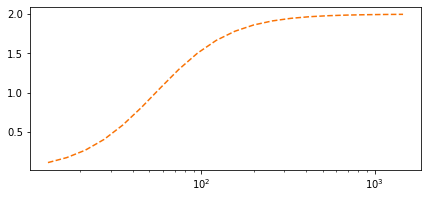

In [8]:
Σ = np.logspace(0, 2.05, 20) * 13

fig = plt.figure(figsize=(7, 3))
plt.plot(Σ, (200*μ)/ (1 + (Σ**-2) * np.exp(8)) + λ, color='xkcd:orange', linestyle='--' )
plt.xscale('log')

In [9]:
from skimage.transform import resize
## Fix seed
rng = default_rng(10)

In [10]:
from matplotlib.colors import to_hex, to_rgb
# Define the transformation: shift, log, and reshift
def transform(y):
    return np.sign(y - 1) * np.log1p(np.abs(y - 1))**0.5

def inverse_transform(y):
    return np.sign(y) * np.expm1(np.abs(y**2)) + 1
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(to_rgb(c1))
    c2 = np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)

In [11]:
A_Spectra = dict()

In [12]:
for nume in range(2,11):

    '''        # –––––––––-–––––––––- Image setup –––––––––-–––––––––- #        '''

    # Retrieve image
    imn = images[nume]
    print('Procesing image ', imn, '.png', sep = '')

    # Image read
    img = imread('../imgs/' + str(nume) + '_' + imn + '.png')

    # Resize and store
    img  = 255 * resize(img, (45,45,3), order=1, anti_aliasing=True)
    img  = asarray(img).astype(float, copy = False)
    N, M = img.shape[:2]
    nm   = N*M
    img  = img[:,:,0]                                          # Select first channel only

    print( "\nImage has dimensions (N,M) =", (N,M), '\nn =', nm)

    # Create noisy sample
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f);

    '''        # –––––––––-–––––––––- Kernel setup –––––––––-–––––––––- #        '''

    print('Seting up kernel ... ', end ='')
    # Patch radius
    ρ = 5
    '''
        Kernel Setup
    '''
    clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')
    ρ̂    = 2*ρ+1

    """Patches"""
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)

    '''Build windows'''
    window_scheme = 'mis'
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list

    num_windows = len(windows)

    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))

    '''Kernel as an explicit object'''
    def Full_W(σ):
        B = np.zeros([nm,nm])
        for l in range(num_windows):
            B += rbf_kernel(X[:,windows[l]], gamma = (σ**-2) )
        B *= k_weight
        return B

    print(num_windows, 'windows have been built.')

    # Bounds on window norms
    fᵂ = [norm(X[:, windows[l]].max(0) - X[:, windows[l]].min(0)) for l in range(num_windows)]



    '''        # –––––––––-–––––––––- Spectrum –––––––––-–––––––––- #        '''

    Exact_Spectrums = np.zeros([20,nm])
    k = 0
    for σ in Σ:
        print('{0:.2e}: '.format(σ), end ='')
        start = time.time()
        ANOVA = Full_W(σ);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
        Exact_Spectrums[k,:] = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
        end = time.time()
        del ANOVA
        k +=1
        print('{0:.2f} '.format(end-start))

    Exact_Spectrums[:,0] = 0.0    # First eigenvalue is zero
    np.clip(Exact_Spectrums, 0.0, μ * nm, out = Exact_Spectrums);    # Clip in case some additional error comes up

    A_Spectra[imn] = {'Σ': Exact_Spectrums, 'Bounds': fᵂ}
    print('–'*50)
    print('\n')

Procesing image baboon.png

Image has dimensions (N,M) = (45, 45) 
n = 2025
Seting up kernel ... 41 windows have been built.
1.30e+01: 3.67 
1.67e+01: 3.04 
2.14e+01: 3.06 
2.74e+01: 3.09 
3.51e+01: 4.06 
4.50e+01: 3.81 
5.77e+01: 3.48 
7.40e+01: 2.92 
9.49e+01: 3.05 
1.22e+02: 2.98 
1.56e+02: 2.88 
2.00e+02: 3.21 
2.56e+02: 2.99 
3.29e+02: 2.83 
4.21e+02: 2.87 
5.40e+02: 2.92 
6.92e+02: 2.93 
8.87e+02: 2.93 
1.14e+03: 2.99 
1.46e+03: 3.01 
––––––––––––––––––––––––––––––––––––––––––––––––––


Procesing image fprint3.png

Image has dimensions (N,M) = (45, 45) 
n = 2025
Seting up kernel ... 41 windows have been built.
1.30e+01: 3.77 
1.67e+01: 3.96 
2.14e+01: 3.09 
2.74e+01: 3.07 
3.51e+01: 2.95 
4.50e+01: 3.14 
5.77e+01: 3.77 
7.40e+01: 2.81 
9.49e+01: 2.96 
1.22e+02: 3.03 
1.56e+02: 2.94 
2.00e+02: 2.76 
2.56e+02: 2.98 
3.29e+02: 2.87 
4.21e+02: 2.88 
5.40e+02: 2.94 
6.92e+02: 2.81 
8.87e+02: 3.48 
1.14e+03: 3.21 
1.46e+03: 2.94 
––––––––––––––––––––––––––––––––––––––––––––––––––


Pro

Visualise results:

Procesing image baboon.png
Procesing image fprint3.png
7
7
6
6
6
6
5
5
5
4
Procesing image cameraman.png
Procesing image monarch.png
Procesing image sails.png
Procesing image fruits.png
8
8
7
7
7
7
6
6
6
5
4
3
2
Procesing image peppers.png
Procesing image mountain.png
Procesing image texmos3.png
3
3
1


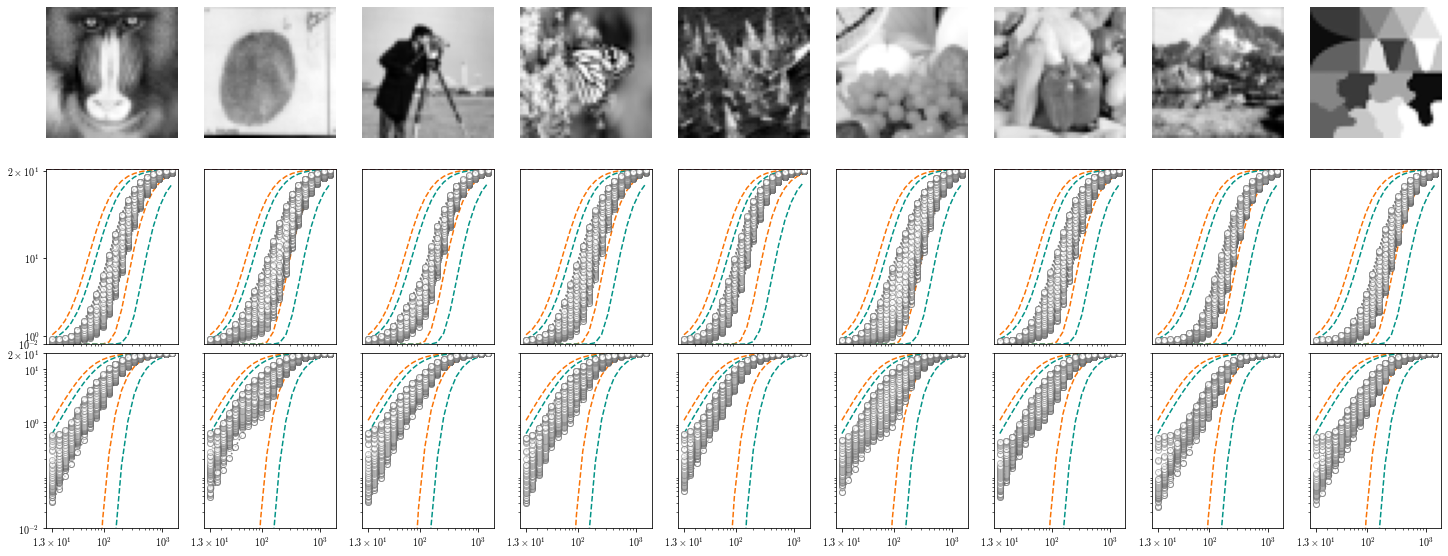

In [69]:
# A - with bounds
fig, ax = plt.subplots(3,9, facecolor='w', figsize=(25,10))


fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)
Index_Range = np.clip(Index_Range,1,nm-1)

# –––––––– Plotting –––––––– #
for i in range(9):

    '''        # –––––––––-–––––––––- Image setup –––––––––-–––––––––- #        '''

    # Retrieve image
    imn = images[i+2]
    print('Procesing image ', imn, '.png', sep = '')

    # Image read
    img = imread('../imgs/' + str(i+2) + '_' + imn + '.png')
    # Resize and store
    img  = 255 * resize(img, (45,45,3), order=1, anti_aliasing=True)
    img  = asarray(img).astype(float, copy = False)
    img  = img[:,:,0]                                          # Select first channel only
    
    # Zeroth panel with picture
    ax[0,i].imshow(img, cmap='gray')
    
    
    # First panel with only log scale in x axes
    kk=1
    ax[1,i].plot(Σ, nm*μ* np.exp(-( min(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:orange', linestyle='--' )
    ax[1,i].plot(Σ, nm*μ* np.exp(-( max(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:teal', linestyle='--' )
    ax[1,i].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8)), color='xkcd:orange', linestyle='--' )
    ax[1,i].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8.6)), color='xkcd:teal', linestyle='--' )
    for k in Index_Range:
        ax[1,i].plot(Σ, A_Spectra[imn]['Σ'][:,k], linestyle=':', marker='o', alpha=0.5, 
                   color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
        kk +=1
    ax[1,i].axhline(y= μ * nm, color='#C14953', linestyle='--')
    ax[1,i].set_ylim(min(Exact_Spectrums[:,1])*0.1, μ * nm)
    ax[1,i].set_xscale('log')

    
    # Second panel with log scale in both axes
    kk=1
    ax[2,i].plot(Σ, nm*μ* np.exp(-( min(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:orange', linestyle='--' )
    ax[2,i].plot(Σ, nm*μ* np.exp(-( max(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:teal', linestyle='--' )
    ax[2,i].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8)), color='xkcd:orange', linestyle='--' )
    ax[2,i].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8.6)), color='xkcd:teal', linestyle='--' )
    for k in Index_Range:
        ax[2,i].plot(Σ, A_Spectra[imn]['Σ'][:,k], linestyle=':', marker='o', alpha=0.5, 
                   color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
        
        Exceeded = ( A_Spectra[imn]['Σ'][:,k] < nm*μ* np.exp(-( min(A_Spectra[imn]['Bounds']) /Σ)**2) )
        if Exceeded.any():
            print(Exceeded.sum())
        kk +=1

    ax[2,i].set_ylim(1e-2, μ * nm)

    # Set scales
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    #ax[0].set_yscale('function', functions=(transform, inverse_transform))
    #ax[0].set_yscale('symlog', linthresh = 3)
    #ax[1,i].set_yscale('symlog', linthresh = 1e-2)
    


    # –––––––– Ticks –––––––– #
    # Add more ticks in x-axis — Second panel
    ax_base = [1, 2, 3]
    ax_val  = [ 1.3, 1, 1]
    ax_loc  = ax_val * 10.0**asarray(ax_base)
    ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
               plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
               for a in zip(ax_loc, ax_base, ax_val) ]
    #ax[0,i].set_xticks(ax_loc, ax_lbl, fontname='CMR10')
    ax[1,i].set_xticks([])
    ax[2,i].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

    # Add more ticks in y-axis — First panel
    ax_base = [-2,   0,  1,1]
    ax_val  = [ 1, 1, 1,2]
    ax_loc  = ax_val * 10.0**asarray(ax_base)
    ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
               plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
               for a in zip(ax_loc, ax_base, ax_val) ]
    ax[1,0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');
    ax[2,0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');
    
    if i > 0:
        ax[1,i].set_yticks([])
        ax[2,i].set_yticks([])
        
    ax[0,i].set_axis_off()

# –––––––– Store –––––––– #
#fig.savefig('Eigs_A_Sigma_Extra.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

---

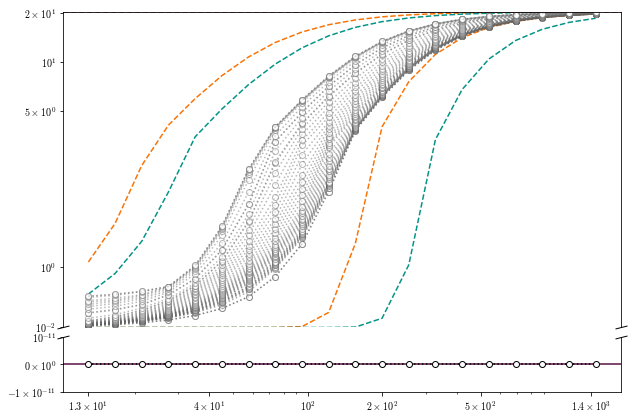

In [75]:
# A - with bounds
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)
Index_Range = np.clip(Index_Range,1,nm-1)

# –––––––– Plotting –––––––– #
kk=1
ax[0].plot(Σ, nm*μ* np.exp(-( min(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:orange', linestyle='--' )
ax[0].plot(Σ, nm*μ* np.exp(-( max(A_Spectra[imn]['Bounds']) /Σ)**2) + λ, color='xkcd:teal', linestyle='--' )
ax[0].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8)), color='xkcd:orange', linestyle='--' )
ax[0].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8.7)), color='xkcd:teal', linestyle='--' )
for k in Index_Range:
    ax[0].plot(Σ, A_Spectra[imn]['Σ'][:,k], linestyle=':', marker='o', alpha=0.5, 
               color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
    kk +=1
ax[0].axhline(y= μ * nm, color='#C14953', linestyle='--')

# The second panel contains the smallest eigenvalues
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].plot(Σ, λ * np.ones_like(Σ), linestyle=':', marker='o', alpha=1, color = 'black', markerfacecolor='white' );
ax[1].set_ylim(-1e-11, 1e-11)

ax[0].set_ylim(min(Exact_Spectrums[:,1])*0.1, μ * nm)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
ax[0].set_yscale('symlog', linthresh = 3)
ax[1].set_yscale('symlog', linthresh = 1e-2)


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-2, 0,  0,  1,1]
ax_val  = [ 1, 1, 5, 1,2]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,0,-11]
ax_val  = [-1,0,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
#fig.savefig('Eigs_A_Sigma_Extra.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [76]:
import pickle as pl

In [78]:
with open('Pics_Spectra.pkl', 'wb') as file: pl.dump(A_Spectra, file)

In [ ]:
#with open("Pics_Spectra.pkl", "rb") as input_file:    A_Spectra = pl.load(input_file)

---

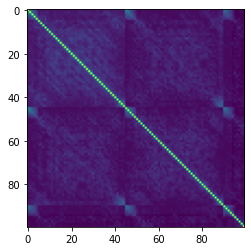

In [56]:
plt.imshow(Out[50][:100,:100])

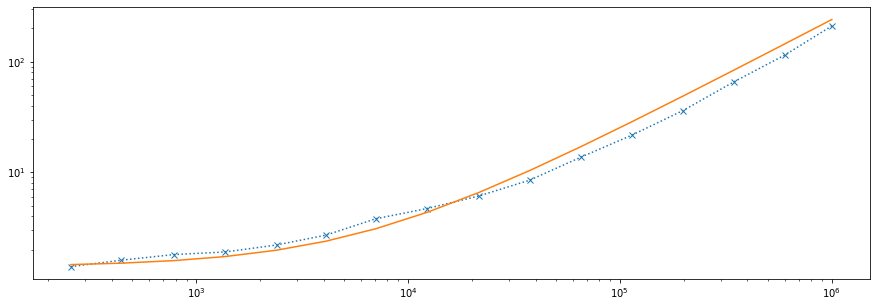

In [27]:
X = np.asarray([256, 441, 784, 1369, 2401, 4096, 7056, 12321, 21609, 37636, 65536, 114244, 198916, 345744, 602176, 1002001])
Y = np.asarray([1.4, 1.6, 1.8, 1.9, 2.2, 2.7, 3.8, 4.7, 6.1, 8.5, 13.7, 21.7, 36.2, 65.8, 115.1, 210.6])

plt.figure(figsize=(15, 5))
plt.loglog(X, Y, 'x:')
plt.loglog(X, (Y[-1] - Y[-2])/( X[-1] - X[-2] ) * X + Y[0])
#plt.loglog(X, (Y[9] - Y[8])/( X[9] - X[8] ) * X + Y[0])
plt.show()

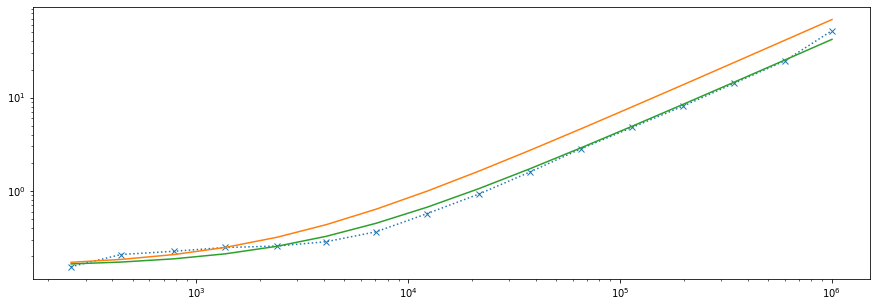

In [28]:
Z = np.asarray([0.154014,0.207811,0.225228,0.247127,0.25613,0.284785,0.364322,0.571632,0.925731,1.596676,2.832239,4.787958,8.115865,14.233722,24.852689,52.183612])
plt.figure(figsize=(15, 5))
plt.loglog(X, Z, 'x:')
plt.loglog(X, (Z[-1] - Z[-2])/( X[-1] - X[-2] ) * X + Z[0])
plt.loglog(X, (Z[9] - Z[8])/( X[9] - X[8] ) * X + Z[0])
plt.show()

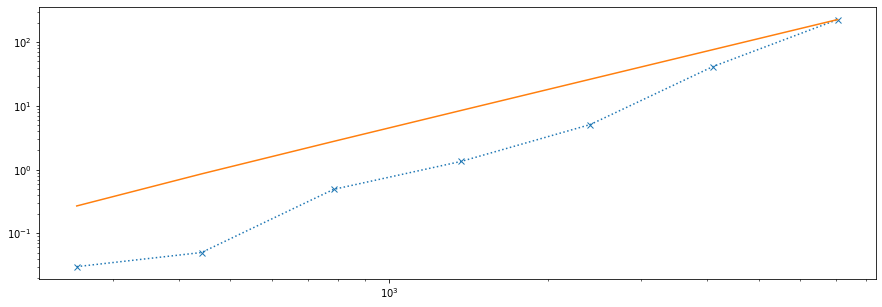

In [54]:
W = np.asarray([0.03, 0.05, 0.49, 1.35, 5.11, 41.49, 227.31])
plt.figure(figsize=(15, 5))
plt.loglog(X[:7], W, 'x:')
plt.loglog(X[:7], (W/X[:7]**2).max() * X[:7]**2 - W[0])
#plt.loglog(X, (Z[9] - Z[8])/( X[9] - X[8] ) * X + Z[0])
plt.show()

In [65]:
np.float64(1).itemsize * (20000**2) / 1024 / 1024 / 1024

2.9802322387695312